Here I'm evaluating how well matrix factorization can work at predicting cross-assay bioactivities from ChEMBL.  Specifically, I'm using training/test sets provided by Eric Martin.

The idea is we have a matrix where the rows are unique compounds and the columns are unique assays.  The matrix is sparse and we want to predict the missing values.

First I'm going to investigate straightforward MF and then, hopefully, experiment with different loss functions and including chemical fingerprints in the matrix.

In [1]:
import numpy as np
import pandas as pd
import glob,re,sys
import matplotlib.pyplot as plt
%matplotlib inline

TomDLT implemented support for missing value imputation, but it doesn't look like it has been merged in yet so using it directly (https://github.com/scikit-learn/scikit-learn/pull/8474)

In [2]:
import nmf

In [3]:
randomtrain = pd.read_csv('chemble-splits/random.train')
randomtest = pd.read_csv('chemble-splits/random.test')
realtrain = pd.read_csv('chemble-splits/realistic.train')
realtest = pd.read_csv('chemble-splits/realistic.test')

In [4]:
#map assay/cmpd ids to indices
assayids = dict()
cmpdids = dict()
idx2cmpd = []
idx2assay = []
smiles = dict()
for table in [randomtrain, randomtest, realtrain, realtest]: #presumably redundant
    for r in table.iterrows():
        if r[1].ID not in cmpdids:
            smiles[len(cmpdids)] = r[1].smiles
            cmpdids[r[1].ID] = len(cmpdids)
            idx2cmpd.append(r[1].ID)
            
        if r[1].AssayID not in assayids:
            assayids[r[1].AssayID] = len(assayids)
            idx2assay.append(r[1].AssayID)

In [5]:
len(cmpdids),len(assayids)

(13190, 159)

In [6]:
def makematrix(data, cmpdids, assayids):
    ret = np.full((len(cmpdids),len(assayids)),np.nan)
    for (rid, row) in data.iterrows():
        r = cmpdids[row.ID]
        c = assayids[row.AssayID]
        ret[r][c] = row.pIC50_exp
    return ret

In [7]:
randomtrain_m = makematrix(randomtrain,cmpdids,assayids)
realtrain_m = makematrix(realtrain,cmpdids,assayids)

In [36]:
len(randomtrain)

85799

In [8]:
#let's see what happens with the defaults
model = nmf.NMF(solver='mu',max_iter=300) #mu required for missing value support
W = model.fit_transform(randomtrain_m)
H = model.components_

nmf.py:1169: ConvergenceWarning: Maximum number of iteration 300 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [9]:
W.shape,H.shape

((13190, 159), (159, 159))

In [10]:
def getpred(pred, data, cmpdids, assayids):
    '''return tuples of (true value, predicted value)'''    
    ret = []
    for (ri, row) in data.iterrows():
        i = cmpdids[row.ID]
        j = assayids[row.AssayID]
        pval = pred[i][j]
        ret.append((row.pIC50_exp,pval))
    return np.array(ret)

In [11]:
pred = np.matmul(W,H)
trainpred = getpred(pred,randomtrain, cmpdids, assayids)
testpred = getpred(pred,randomtest,cmpdids,assayids)

In [12]:
print "Pearson R, train =",np.corrcoef(trainpred.T)[0][1],"test =",np.corrcoef(testpred.T)[0][1]

Pearson R, train = 0.994599188171 test = 0.319689666416


Clearly we are overfitting..

(0, 12)

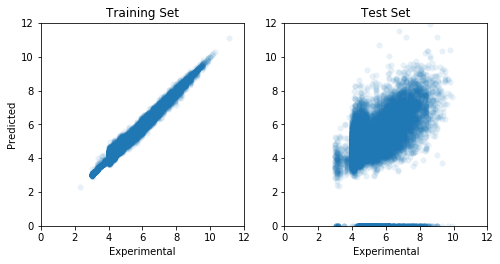

In [13]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpred[:,0],trainpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpred[:,0],testpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

Huh, so actually if you remove the zero-predicted values it's not so bad...

In [14]:
from sklearn.metrics import mean_squared_error
testnotzero = testpred[testpred[:,1] > 0]
print "Pearson R =",np.corrcoef(testnotzero.T)[0][1],"RMSE", mean_squared_error(testnotzero[:,0],testnotzero[:,1])

Pearson R = 0.687457775981 RMSE 0.652639877358


90% are non-zero

In [15]:
len(testnotzero)/float(len(testpred))

0.9007293639105126

So what happens if we optimize the model parameters?
 * *alpha* - amount of regularization (default 0)
 * *l1_ratio* - L1 vs L2 ratio, default 0 is all L2
 * *n_components* - number of components (default all) 

In [17]:
#this takes a loooong time despite being a rather course grid search
results = []
for alpha in [0,0.01,1]:
    for l1_ratio in [0,0.5,1]:
            for ncomponents in range(9,160,10):
                model = nmf.NMF(solver='mu',alpha=alpha,l1_ratio=l1_ratio,n_components=ncomponents,init='random')
                W = model.fit_transform(randomtrain_m)
                H = model.components_
                pred = np.matmul(W,H)
                trainpred = getpred(pred,randomtrain, cmpdids, assayids)
                testpred = getpred(pred,randomtest,cmpdids,assayids)
                testnotzero = testpred[testpred[:,1] > 0]
                trainR = np.corrcoef(trainpred.T)[0][1]
                testR = np.corrcoef(testpred.T)[0][1]
                testRnz = np.corrcoef(testnotzero.T)[0][1]

                trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
                testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
                testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])
                results.append((alpha,l1_ratio,ncomponents,trainR,trainRMS, testR,testRMS, testRnz,testRMSnz))
                

nmf.py:1169: ConvergenceWarning: Maximum number of iteration 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [18]:
gridres = pd.DataFrame(results,columns=['alpha','l1_ratio','ncomponents','trainR','trainRMS','testR','testRMS','testRnz','testRMSnz'])

In [19]:
gridres.sort_values('testRnz',ascending=False)

,alpha,l1_ratio,ncomponents,trainR,trainRMS,testR,testRMS,testRnz,testRMSnz
33,0.00,1.0,19,0.895699,0.222356,0.346864,3.135285,0.747117,0.525983
49,0.01,0.0,19,0.893582,0.226648,0.345039,3.135138,0.746179,0.525821
48,0.01,0.0,9,0.850361,0.311262,0.332489,3.132146,0.742896,0.522500
1,0.00,0.0,19,0.895701,0.222368,0.345210,3.147435,0.741012,0.539474
80,0.01,1.0,9,0.855507,0.301422,0.336278,3.139376,0.740702,0.530526
64,0.01,0.5,9,0.849831,0.312333,0.329542,3.137647,0.739275,0.528607
17,0.00,0.5,19,0.893706,0.226390,0.342050,3.153485,0.737213,0.546189
97,1.00,0.0,19,0.894979,0.224257,0.339735,3.150319,0.737016,0.542674
96,1.00,0.0,9,0.852044,0.308320,0.330037,3.143666,0.736429,0.535289
32,0.00,1.0,9,0.848983,0.313920,0.330449,3.146433,0.735574,0.538361


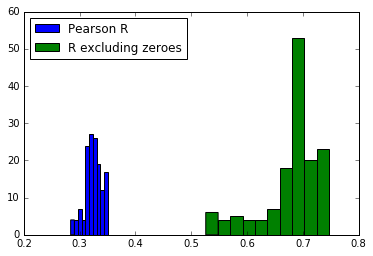

In [20]:
plt.hist(gridres.testR,label="Pearson R")
plt.hist(gridres.testRnz,label="R excluding zeroes")
plt.legend(loc='best')

Interestingly, the best models didn't use L1/L2 regularization (alpha=0) but had a limited number of components (which is probably also effective at preventing overfitting).

In [21]:
secondresults = []
for ncomponents in range(5,60,5):
    model = nmf.NMF(solver='mu',n_components=ncomponents,init='random')
    W = model.fit_transform(randomtrain_m)
    H = model.components_
    pred = np.matmul(W,H)
    trainpred = getpred(pred,randomtrain, cmpdids, assayids)
    testpred = getpred(pred,randomtest,cmpdids,assayids)
    testnotzero = testpred[testpred[:,1] > 0]
    trainR = np.corrcoef(trainpred.T)[0][1]
    testR = np.corrcoef(testpred.T)[0][1]
    testRnz = np.corrcoef(testnotzero.T)[0][1]

    trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
    testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
    testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])
    secondresults.append((ncomponents,trainR,trainRMS, testR,testRMS, testRnz,testRMSnz))

In [22]:
grid2res = pd.DataFrame(secondresults,columns=['ncomponents','trainR','trainRMS','testR','testRMS','testRnz','testRMSnz'])

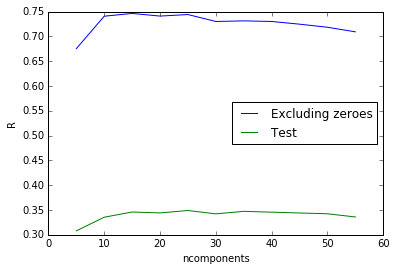

In [176]:
plt.plot(grid2res.ncomponents,grid2res.testRnz,label='Excluding zeroes')
plt.plot(grid2res.ncomponents,grid2res.testR,label='Test')
plt.legend(loc='best')
plt.xlabel('ncomponents')
plt.ylabel('R')

So something like 25 components for this dataset.. now let's see how we do with the realistic set.

In [164]:
model = nmf.NMF(solver='mu',n_components=25,init='random')
W = model.fit_transform(realtrain_m)
H = model.components_
pred = np.matmul(W,H)
trainpred = getpred(pred,realtrain, cmpdids, assayids)
testpred = getpred(pred,realtest,cmpdids,assayids)
testnotzero = testpred[testpred[:,1] > 0]
trainR = np.corrcoef(trainpred.T)[0][1]
testR = np.corrcoef(testpred.T)[0][1]
testRnz = np.corrcoef(testnotzero.T)[0][1]

trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])

(0, 12)

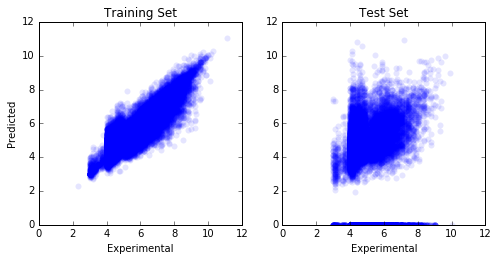

In [25]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpred[:,0],trainpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpred[:,0],testpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

In [26]:
print "Pearson R =",np.corrcoef(testnotzero.T)[0][1],"RMSE", mean_squared_error(testnotzero[:,0],testnotzero[:,1])

Pearson R = 0.465892248144 RMSE 0.965636203142


In [27]:
len(testnotzero)/float(len(testpred))

0.6933227859480062

As expected, we do worse and there are more zeroes (presumably cases where there simply isn't information in the training set on the assay or compound).


So what happens if we add fingerprints to the matrix?  This would let the model tie data together using chemical similarity, however traditional matrix factorization is unlikely to be ideal as the same norm is applied to the whole matrix despite the matrix containing two very different types of data (fingerprint bits and affinities).

Nonetheless, let's see what happens.

In [ ]:
from rdkit.Chem import AllChem as Chem

In [13]:
mol =Chem.MolFromSmiles(randomtrain.smiles[0])
bv = Chem.GetMorganFingerprintAsBitVect(mol,2)

In [14]:
def makefpmatrix(data, cmpdids, assayids):
    fpsize = 2048
    ret = np.full((len(cmpdids),len(assayids)+fpsize),np.nan)
    for (rid, row) in data.iterrows():
        r = cmpdids[row.ID]
        c = assayids[row.AssayID]
        ret[r][c] = row.pIC50_exp
    start = len(assayids)
    for (r,smi) in smiles.iteritems():
        mol =Chem.MolFromSmiles(smi)
        bv = Chem.GetMorganFingerprintAsBitVect(mol,2)
        for i in xrange(bv.GetNumBits()):
            ret[r][start+i] = float(bv.GetBit(i))
    return ret

In [15]:
randomfp = makefpmatrix(randomtrain,cmpdids,assayids)

In [16]:
randomfp.shape

(13190, 2207)

In [20]:
np.count_nonzero(np.isfinite(randomfp))

27098919

In [139]:
model = nmf.NMF(solver='mu') 
W = model.fit_transform(randomfp)
H = model.components_

In [140]:
pred = np.matmul(W,H)
trainpredfp = getpred(pred,randomtrain, cmpdids, assayids)

In [141]:
testpredfp = getpred(pred,randomtest, cmpdids, assayids)

In [142]:
print "Pearson R, train =",np.corrcoef(trainpredfp.T)[0][1],"test =",np.corrcoef(testpredfp.T)[0][1]

Pearson R, train = 0.998826371279 test = 0.186963880338


More data == lots of overfitting

In [143]:
fpresults = []
for ncomponents in range(10,101,10):
    model = nmf.NMF(solver='mu',n_components=ncomponents,init='random')
    W = model.fit_transform(randomfp)
    H = model.components_
    pred = np.matmul(W,H)
    trainpred = getpred(pred,randomtrain, cmpdids, assayids)
    testpred = getpred(pred,randomtest,cmpdids,assayids)
    testnotzero = testpred[testpred[:,1] > 0]
    trainR = np.corrcoef(trainpred.T)[0][1]
    testR = np.corrcoef(testpred.T)[0][1]
    testRnz = np.corrcoef(testnotzero.T)[0][1]

    trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
    testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
    testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])
    fpresults.append((ncomponents,trainR,trainRMS, testR,testRMS, testRnz,testRMSnz))

In [144]:
fpgridres = pd.DataFrame(fpresults,columns=['ncomponents','trainR','trainRMS','testR','testRMS','testRnz','testRMSnz'])

(0, 12)

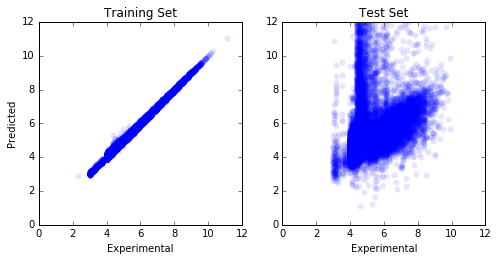

In [145]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpredfp[:,0],trainpredfp[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpredfp[:,0],testpredfp[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

In [146]:
fptestnotzero = testpredfp[testpredfp[:,1] > 0]
print "Pearson R =",np.corrcoef(fptestnotzero.T)[0][1],"RMSE", mean_squared_error(fptestnotzero[:,0],fptestnotzero[:,1])

Pearson R = 0.186963880338 RMSE 10.1003843403


The zeroes are gone. My expectation was that the FP bits would help link compounds together.  Some of the test predictions are WAY off.

In [147]:
np.max(testpredfp)

186.81968087998675

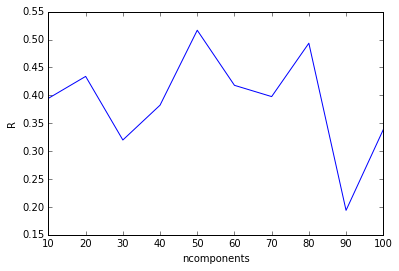

In [148]:
plt.plot(fpgridres.ncomponents,fpgridres.testRnz,label='Excluding zeroes')
plt.xlabel('ncomponents')
plt.ylabel('R')

Huh, so the matrix including fingerprints has a crazy amount of variation given the number of components and doesn't do better than the matrix without them.  Perhaps it isn't converging?

In [163]:
model = nmf.NMF(solver='mu',n_components=50,init='random',max_iter=1000)
W = model.fit_transform(randomfp)
H = model.components_
pred = np.matmul(W,H)
trainpredfp = getpred(pred,randomtrain, cmpdids, assayids)
testpredfp = getpred(pred,randomtest,cmpdids,assayids)

In [169]:
trainR = np.corrcoef(trainpredfp.T)[0][1]
testR = np.corrcoef(testpredfp.T)[0][1]

trainRMS = mean_squared_error(trainpredfp[:,0],trainpredfp[:,1])
testRMS = mean_squared_error(testpredfp[:,0],testpredfp[:,1])


In [170]:
trainR,testR

(0.95717342439760356, 0.36611301400387891)

(0, 12)

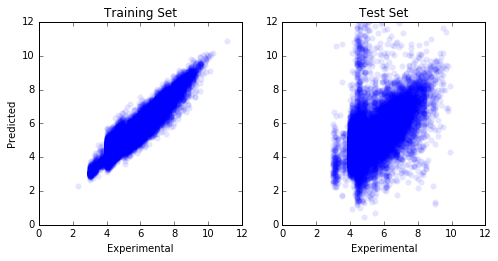

In [172]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpredfp[:,0],trainpredfp[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpredfp[:,0],testpredfp[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)


I'm not going to bother with the realistic set.  It's clear there is a portion of the data that isn't susceptible to interpolation using a linear model. Even with the inclusion of fingerprints, a large number of compounds get assigned a "default" value close to the mean.

Including fingerprints doesn't help other than removing the zero compounds.  This doesn't totally surprise me since I think you need a different loss function for the fingerprints vs. the affinity data in the reconstructed matrix.

In [177]:
randomtrain.mean()

pIC50_exp          5.011075
pIC50_pred         5.011076
AssayID       795668.238289
dtype: float64

Let's see if regularization buys us anything.

In [178]:
model = nmf.NMF(solver='mu',n_components=50,init='random',alpha=0.1)
W = model.fit_transform(randomfp)
H = model.components_
pred = np.matmul(W,H)
trainpredfp = getpred(pred,randomtrain, cmpdids, assayids)
testpredfp = getpred(pred,randomtest,cmpdids,assayids)

(0, 12)

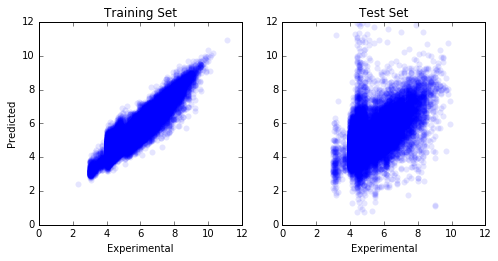

In [179]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpredfp[:,0],trainpredfp[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpredfp[:,0],testpredfp[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)


In [187]:
trainR = np.corrcoef(trainpredfp.T)[0][1]
testR = np.corrcoef(testpredfp.T)[0][1]

trainRMS = mean_squared_error(trainpredfp[:,0],trainpredfp[:,1])
testRMS = mean_squared_error(testpredfp[:,0],testpredfp[:,1])

trainR,testR

(0.94058380193575042, 0.60436222431119468)

Apparently regularization helps quite a bit, let's redo the grid search.

In [ ]:
fpresults = []
for alpha in [0.01,.1,1]:
    for l1_ratio in [0,0.5,1]:
            for ncomponents in [25,50,100]:
                model = nmf.NMF(solver='mu',alpha=alpha,l1_ratio=l1_ratio,n_components=ncomponents,init='random')
                W = model.fit_transform(randomfp)
                H = model.components_
                pred = np.matmul(W,H)
                trainpred = getpred(pred,randomtrain, cmpdids, assayids)
                testpred = getpred(pred,randomtest,cmpdids,assayids)
                testnotzero = testpred[testpred[:,1] > 0]
                trainR = np.corrcoef(trainpred.T)[0][1]
                testR = np.corrcoef(testpred.T)[0][1]
                testRnz = np.corrcoef(testnotzero.T)[0][1]

                trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
                testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
                testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])
                fpresults.append((alpha,l1_ratio,ncomponents,trainR,trainRMS, testR,testRMS, testRnz,testRMSnz))

In [188]:
gridfpres = pd.DataFrame(fpresults,columns=['alpha','l1_ratio','ncomponents','trainR','trainRMS','testR','testRMS','testRnz','testRMSnz'])

In [190]:
gridfpres.sort_values('testR',ascending=False)[:10]

,alpha,l1_ratio,ncomponents,trainR,trainRMS,testR,testRMS,testRnz,testRMSnz
18,1.00,0.0,25,0.898178,0.219105,0.654802,0.725218,0.654802,0.725218
19,1.00,0.0,50,0.927432,0.159956,0.650619,0.738860,0.650619,0.738860
20,1.00,0.0,100,0.953198,0.106278,0.641593,0.761864,0.641593,0.761864
22,1.00,0.5,50,0.923886,0.166429,0.609304,0.899634,0.609304,0.899634
4,0.01,0.5,50,0.943097,0.124894,0.598551,0.935874,0.598551,0.935874
10,0.10,0.0,50,0.942407,0.126577,0.593450,0.947865,0.593450,0.947865
23,1.00,0.5,100,0.949096,0.113364,0.583688,0.985286,0.583688,0.985286
21,1.00,0.5,25,0.895401,0.224405,0.578370,1.007175,0.578370,1.007175
2,0.01,0.0,100,0.970198,0.066698,0.572575,1.012669,0.572575,1.012669
25,1.00,1.0,50,0.925670,0.161603,0.568790,1.072897,0.568790,1.072897


In [192]:
gridfpres.sort_values('testRMS',ascending=True)[:10]

,alpha,l1_ratio,ncomponents,trainR,trainRMS,testR,testRMS,testRnz,testRMSnz
18,1.00,0.0,25,0.898178,0.219105,0.654802,0.725218,0.654802,0.725218
19,1.00,0.0,50,0.927432,0.159956,0.650619,0.738860,0.650619,0.738860
20,1.00,0.0,100,0.953198,0.106278,0.641593,0.761864,0.641593,0.761864
22,1.00,0.5,50,0.923886,0.166429,0.609304,0.899634,0.609304,0.899634
4,0.01,0.5,50,0.943097,0.124894,0.598551,0.935874,0.598551,0.935874
10,0.10,0.0,50,0.942407,0.126577,0.593450,0.947865,0.593450,0.947865
23,1.00,0.5,100,0.949096,0.113364,0.583688,0.985286,0.583688,0.985286
21,1.00,0.5,25,0.895401,0.224405,0.578370,1.007175,0.578370,1.007175
2,0.01,0.0,100,0.970198,0.066698,0.572575,1.012669,0.572575,1.012669
11,0.10,0.0,100,0.967755,0.072396,0.556565,1.054272,0.556565,1.054272


For both R and RMS more regularization is better (fewer components, larger alpha).  L2 regularization is strongly prefered to L1.

In [195]:
#evaluate larger alpha
fpresults2 = []
for alpha in [1,2,4,8]:
    model = nmf.NMF(solver='mu',alpha=alpha,n_components=25,init='random')
    W = model.fit_transform(randomfp)
    H = model.components_
    pred = np.matmul(W,H)
    trainpred = getpred(pred,randomtrain, cmpdids, assayids)
    testpred = getpred(pred,randomtest,cmpdids,assayids)
    testnotzero = testpred[testpred[:,1] > 0]
    trainR = np.corrcoef(trainpred.T)[0][1]
    testR = np.corrcoef(testpred.T)[0][1]
    testRnz = np.corrcoef(testnotzero.T)[0][1]

    trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
    testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
    testRMSnz = mean_squared_error(testnotzero[:,0],testnotzero[:,1])
    fpresults2.append((alpha,l1_ratio,ncomponents,trainR,trainRMS, testR,testRMS, testRnz,testRMSnz))

In [196]:
gridfpres2 = pd.DataFrame(fpresults2,columns=['alpha','l1_ratio','ncomponents','trainR','trainRMS','testR','testRMS','testRnz','testRMSnz'])

In [197]:
gridfpres2

,alpha,l1_ratio,ncomponents,trainR,trainRMS,testR,testRMS,testRnz,testRMSnz
0,1,1,100,0.896172,0.223343,0.606145,0.880539,0.606145,0.880539
1,2,1,100,0.884905,0.247272,0.649510,0.729915,0.649510,0.729915
2,4,1,100,0.874771,0.269151,0.600414,0.887892,0.600414,0.887892
3,8,1,100,0.857825,0.306887,0.570753,0.982499,0.570753,0.982499


Huh, a certain lack of reproducibility due to random initialization.

In [198]:
fpresults3 = []
for i in xrange(5):
    model = nmf.NMF(solver='mu',alpha=2,n_components=25,init='random')
    W = model.fit_transform(randomfp)
    H = model.components_
    pred = np.matmul(W,H)
    trainpred = getpred(pred,randomtrain, cmpdids, assayids)
    testpred = getpred(pred,randomtest,cmpdids,assayids)
    testnotzero = testpred[testpred[:,1] > 0]
    trainR = np.corrcoef(trainpred.T)[0][1]
    testR = np.corrcoef(testpred.T)[0][1]

    trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
    testRMS = mean_squared_error(testpred[:,0],testpred[:,1])
    fpresults3.append((i,trainR,trainRMS, testR,testRMS))

In [200]:
gridfpres3 = pd.DataFrame(fpresults3,columns=['i','trainR','trainRMS','testR','testRMS'])

In [201]:
gridfpres3 #just to get a sense for the amount of variability in the solver

,i,trainR,trainRMS,testR,testRMS
0,0,0.888807,0.239611,0.638069,0.770297
1,1,0.887400,0.242361,0.652118,0.722700
2,2,0.886177,0.244806,0.654170,0.726952
3,3,0.887182,0.242778,0.646228,0.743245
4,4,0.889548,0.238324,0.657093,0.710361


Okay, let's try the realistic set...

In [203]:
realfp = makefpmatrix(realtrain,cmpdids,assayids)

In [231]:
model = nmf.NMF(solver='mu',alpha=2,n_components=25,init='random')
W = model.fit_transform(realfp)
H = model.components_
pred = np.matmul(W,H)
trainpred = getpred(pred,realtrain, cmpdids, assayids)
testpred = getpred(pred,realtest,cmpdids,assayids)

trainR = np.corrcoef(trainpred.T)[0][1]
testR = np.corrcoef(testpred.T)[0][1]

trainRMS = mean_squared_error(trainpred[:,0],trainpred[:,1])
testRMS = mean_squared_error(testpred[:,0],testpred[:,1])


In [232]:
print "Train R",trainR,"Test R",testR,"trainRMS",trainRMS,"testRMS",testRMS

Train R 0.892861816512 Test R 0.234525040609 trainRMS 0.246094581917 testRMS 3.24030288484


(0, 12)

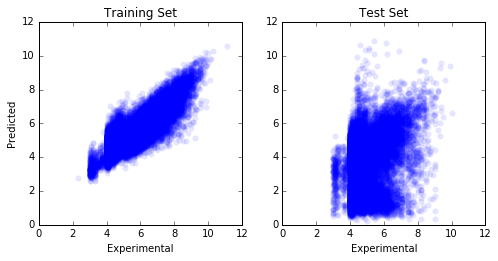

In [233]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(trainpred[:,0],trainpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Training Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpred[:,0],testpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_title("Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)


What if we exclude the compounds with only fingerprint information (this is a roundabout way to do that - filter compounds that were predicted zero without the fp bits).

In [234]:
model = nmf.NMF(solver='mu',n_components=25,init='random')
W = model.fit_transform(realtrain_m)
H = model.components_
pred = np.matmul(W,H)
nontrainpred = getpred(pred,realtrain, cmpdids, assayids)
nontestpred = getpred(pred,realtest,cmpdids,assayids)

In [235]:
nonzerotest = testpred[nontestpred[:,1] != 0]

In [236]:
print "With FP, easy cmpds:",np.corrcoef(nonzerotest.T)[0][1], mean_squared_error(nonzerotest[:,0],nonzerotest[:,1])

With FP, easy cmpds: 0.52520490486 0.828657338832


In [237]:
nonzeronofp = nontestpred[nontestpred[:,1] != 0]
print "Without FP, easy cmpds:",np.corrcoef(nonzeronofp.T)[0][1], mean_squared_error(nonzeronofp[:,0],nonzeronofp[:,1])

Without FP, easy cmpds: 0.484514133186 0.913270909005


In [238]:
print "With FP, all cmpds:",np.corrcoef(testpred.T)[0][1], mean_squared_error(testpred[:,0],testpred[:,1])

With FP, all cmpds: 0.234525040609 3.24030288484


In [239]:
print "Without FP, all cmpds:",np.corrcoef(nontestpred.T)[0][1], mean_squared_error(nontestpred[:,0],nontestpred[:,1])

Without FP, all cmpds: 0.109809581411 8.23010254419


(0, 12)

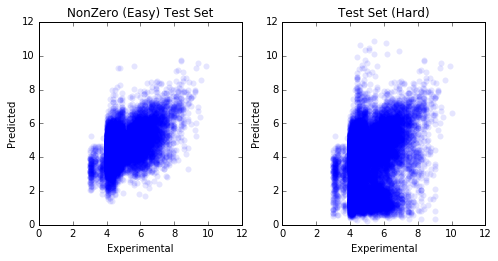

In [240]:
fig = plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.plot(nonzerotest[:,0],nonzerotest[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("NonZero (Easy) Test Set")
ax.set_ylim(0,12)
ax.set_xlim(0,12)

ax = plt.subplot(1,2,2)
ax.plot(testpred[:,0],testpred[:,1],'o',alpha=.1,markeredgewidth=0)
ax.set_aspect('equal')
ax.set_xlabel('Experimental')
ax.set_ylabel('Predicted')
ax.set_title("Test Set (Hard)")
ax.set_ylim(0,12)
ax.set_xlim(0,12)


In [37]:
randomtrain

,ID,pIC50_exp,pIC50_pred,AssayID,smiles
0,PUUFDS,3.301,4.474,654926,CCN(CC)CCN=C(O)c1c(C)[nH]c(/C=C2\C(O)=Nc3ccc(F...
1,PUYDIF,3.301,3.380,654926,CNC(=O)c1cc(Oc2ccc(NC(O)=Nc3ccc(Cl)c(C(F)(F)F)...
2,PUYDQN,3.301,1.947,654926,Cc1nc(Nc2ncc(C(O)=Nc3c(C)cccc3Cl)s2)cc(N2CCN(C...
3,PVSOFX,6.377,6.336,654926,CC(C)(C)n1nc(-c2ccc3ccccc3c2)c2c(N)ncnc21
4,PVSOGA,7.538,6.244,654926,Cn1nc(-c2ccc3ccccc3c2)c2c(N)ncnc21
5,PVSOGB,6.398,5.164,654926,Nc1ccc(-c2n[nH]c3ncnc(N)c23)cc1
6,PVSOGC,4.996,6.636,654926,CC(C)n1nc(-c2cncnc2)c2c(N)ncnc21
7,PVSOGD,6.658,6.583,654926,Nc1ncnc2c1c(-c1ccc3occc3c1)nn2C1CCCC1
8,PVSOGE,6.762,6.803,654926,Cc1ccc(-c2nn(C)c3ncnc(N)c23)cc1O
9,PVSOGF,7.921,6.940,654926,Cn1nc(-c2ccc(Br)c(O)c2)c2c(N)ncnc21


In [8]:
allrandom = pd.concat([randomtrain,randomtest])

In [9]:
out = open('allvalues.csv','w')
for (rid, row) in allrandom.iterrows():
    r = cmpdids[row.ID]
    c = assayids[row.AssayID]
    out.write('%d,%d,%f\n' % (r,c,row.pIC50_exp))
start = len(assayids)
out.close()
out = open('allfp.csv','w')
for (r,smi) in smiles.iteritems():
    mol =Chem.MolFromSmiles(smi)
    bv = Chem.GetMorganFingerprintAsBitVect(mol,2)
    for i in xrange(bv.GetNumBits()):
        out.write('%d,%d,%d\n' % (r,start+i,bv.GetBit(i)))
out.close()

NameError: name 'Chem' is not defined

In [46]:
len(cmpdids)

13190

In [47]:
len(assayids)

159

In [50]:
(len(allrandom)-10000)/float(len(cmpdids)*len(assayids))

0.04974084617181875